# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

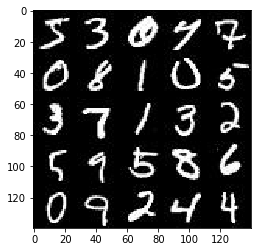

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

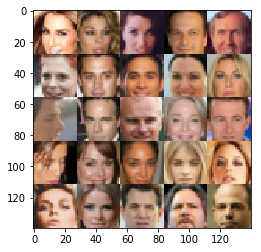

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        layers = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        layers = tf.maximum(alpha * layers, layers)
        #layers = tf.nn.relu(layers)

        layers = tf.layers.conv2d(layers, 128, 3, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=True)
        layers = tf.maximum(alpha * layers, layers)
        #layers = tf.nn.relu(layers)

        layers = tf.layers.conv2d(layers, 256, 3, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=True)
        layers = tf.maximum(alpha * layers, layers)
        #layers = tf.nn.relu(layers)
        
        flatten = tf.reshape(layers, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.1
    with tf.variable_scope('generator', reuse=not is_train):
        layers = tf.layers.dense(z, 7*7*1024)
        layers = tf.reshape(layers, (-1, 7, 7, 1024))
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)
        #layers = tf.nn.relu(layers)

        layers = tf.layers.conv2d_transpose(layers, 512, 3, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=is_train)
        r1 = tf.nn.relu(layers)
                
        layers = tf.layers.conv2d_transpose(layers, 256, 3, strides=2, padding='same')
        layers = tf.layers.batch_normalization(layers, training=is_train)
        layers = tf.maximum(alpha * layers, layers)
        #layers = tf.nn.relu(layers)

        layers = tf.layers.conv2d_transpose(layers, out_channel_dim, 3, strides=2, padding='same')
        layers = tf.image.resize_images(layers, size=(28, 28))
        
        output = tf.nn.tanh(layers)
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                          labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print("Parameters:")
    print("epoch_count: {}".format(epoch_count))
    print("batch_size: {}".format(batch_size))
    print("z_dim: {}".format(z_dim))
    print("learning_rate: {}".format(learning_rate))
    print("beta1: {}".format(beta1))
    print("data_shape: {}".format(data_shape))
    
    if data_image_mode == "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print("Getting model inputs... Ok")
    
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    print("Calculating model loss... Ok")
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    print("Getting model optimizers ... Ok")

    count = 1;    
    t = time.process_time()

    losses = []
    print("Starting training")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                sess.run(d_opt, feed_dict = {lr: learning_rate, real_input: batch_images, z_input : batch_z})
                sess.run(g_opt, feed_dict = {lr: learning_rate, z_input: batch_z})
                
                if count % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    losses.append((train_loss_d, train_loss_g))
                    elapsed_time = time.process_time() - t
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, count),
                          "d_loss: {:.4f}...".format(train_loss_d),
                          "g_loss: {:.4f}".format(train_loss_g),
                          "Elapsed: {0:g}m{0:g}s".format(elapsed_time//60,elapsed_time % 60))
                    
                if count % 100 == 0:
                    print("Sample output")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)

                count +=1
    
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator')
    pyplot.plot(losses.T[1], label='Generator')
    pyplot.title("Training Losses")
    pyplot.legend()
    print("Training done")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Parameters:
epoch_count: 2
batch_size: 32
z_dim: 100
learning_rate: 0.0002
beta1: 0.5
data_shape: (60000, 28, 28, 1)
Getting model inputs... Ok
Calculating model loss... Ok
Getting model optimizers ... Ok
Starting training
Epoch 1/2... Step 10... d_loss: 1.8067... g_loss: 0.3616 Elapsed: 0m0s
Epoch 1/2... Step 20... d_loss: 1.4424... g_loss: 0.4829 Elapsed: 0m0s
Epoch 1/2... Step 30... d_loss: 0.7536... g_loss: 1.8444 Elapsed: 0m0s
Epoch 1/2... Step 40... d_loss: 1.6816... g_loss: 0.3900 Elapsed: 0m0s
Epoch 1/2... Step 50... d_loss: 1.4499... g_loss: 0.6133 Elapsed: 0m0s
Epoch 1/2... Step 60... d_loss: 1.8760... g_loss: 0.3455 Elapsed: 0m0s
Epoch 1/2... Step 70... d_loss: 1.6663... g_loss: 0.5179 Elapsed: 0m0s
Epoch 1/2... Step 80... d_loss: 1.6335... g_loss: 0.5404 Elapsed: 0m0s
Epoch 1/2... Step 90... d_loss: 1.5671... g_loss: 0.6184 Elapsed: 0m0s
Epoch 1/2... Step 100... d_loss: 1.5648... g_loss: 0.6309 Elapsed: 0m0s
Sample output


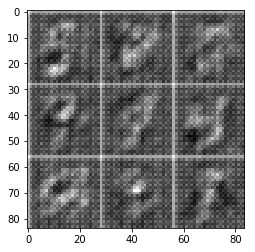

Epoch 1/2... Step 110... d_loss: 1.6686... g_loss: 0.3917 Elapsed: 0m0s
Epoch 1/2... Step 120... d_loss: 1.6187... g_loss: 0.6545 Elapsed: 0m0s
Epoch 1/2... Step 130... d_loss: 1.4443... g_loss: 0.8400 Elapsed: 0m0s
Epoch 1/2... Step 140... d_loss: 1.3861... g_loss: 0.6160 Elapsed: 0m0s
Epoch 1/2... Step 150... d_loss: 1.5159... g_loss: 0.7748 Elapsed: 1m1s
Epoch 1/2... Step 160... d_loss: 1.3186... g_loss: 0.6390 Elapsed: 1m1s
Epoch 1/2... Step 170... d_loss: 1.3832... g_loss: 0.6429 Elapsed: 1m1s
Epoch 1/2... Step 180... d_loss: 1.3194... g_loss: 0.6025 Elapsed: 1m1s
Epoch 1/2... Step 190... d_loss: 1.0992... g_loss: 0.9563 Elapsed: 1m1s
Epoch 1/2... Step 200... d_loss: 1.4970... g_loss: 0.4410 Elapsed: 1m1s
Sample output


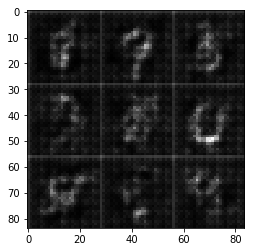

Epoch 1/2... Step 210... d_loss: 1.3973... g_loss: 0.5585 Elapsed: 1m1s
Epoch 1/2... Step 220... d_loss: 0.8934... g_loss: 1.2798 Elapsed: 1m1s
Epoch 1/2... Step 230... d_loss: 0.8719... g_loss: 1.2909 Elapsed: 1m1s
Epoch 1/2... Step 240... d_loss: 1.0746... g_loss: 0.9536 Elapsed: 1m1s
Epoch 1/2... Step 250... d_loss: 1.1092... g_loss: 0.7749 Elapsed: 1m1s
Epoch 1/2... Step 260... d_loss: 0.9145... g_loss: 1.2572 Elapsed: 1m1s
Epoch 1/2... Step 270... d_loss: 1.0989... g_loss: 1.0129 Elapsed: 1m1s
Epoch 1/2... Step 280... d_loss: 1.2610... g_loss: 0.6392 Elapsed: 1m1s
Epoch 1/2... Step 290... d_loss: 1.3127... g_loss: 0.6366 Elapsed: 2m2s
Epoch 1/2... Step 300... d_loss: 1.2875... g_loss: 0.6176 Elapsed: 2m2s
Sample output


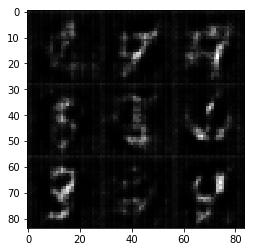

Epoch 1/2... Step 310... d_loss: 1.1446... g_loss: 0.7605 Elapsed: 2m2s
Epoch 1/2... Step 320... d_loss: 1.1256... g_loss: 0.7969 Elapsed: 2m2s
Epoch 1/2... Step 330... d_loss: 1.1581... g_loss: 0.8248 Elapsed: 2m2s
Epoch 1/2... Step 340... d_loss: 1.1497... g_loss: 0.6879 Elapsed: 2m2s
Epoch 1/2... Step 350... d_loss: 0.9836... g_loss: 1.1411 Elapsed: 2m2s
Epoch 1/2... Step 360... d_loss: 1.0903... g_loss: 0.8936 Elapsed: 2m2s
Epoch 1/2... Step 370... d_loss: 1.1719... g_loss: 1.1396 Elapsed: 2m2s
Epoch 1/2... Step 380... d_loss: 1.2016... g_loss: 0.6961 Elapsed: 2m2s
Epoch 1/2... Step 390... d_loss: 0.9228... g_loss: 1.1915 Elapsed: 2m2s
Epoch 1/2... Step 400... d_loss: 1.8613... g_loss: 0.2809 Elapsed: 2m2s
Sample output


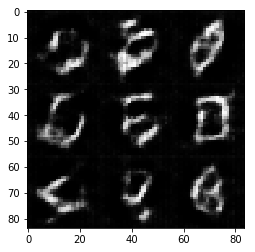

Epoch 1/2... Step 410... d_loss: 1.6412... g_loss: 0.4145 Elapsed: 2m2s
Epoch 1/2... Step 420... d_loss: 0.9061... g_loss: 1.1059 Elapsed: 2m2s
Epoch 1/2... Step 430... d_loss: 1.4429... g_loss: 0.5251 Elapsed: 2m2s
Epoch 1/2... Step 440... d_loss: 1.3056... g_loss: 0.6349 Elapsed: 3m3s
Epoch 1/2... Step 450... d_loss: 1.3505... g_loss: 0.5814 Elapsed: 3m3s
Epoch 1/2... Step 460... d_loss: 1.2141... g_loss: 0.9617 Elapsed: 3m3s
Epoch 1/2... Step 470... d_loss: 1.3755... g_loss: 0.5273 Elapsed: 3m3s
Epoch 1/2... Step 480... d_loss: 1.4524... g_loss: 0.6678 Elapsed: 3m3s
Epoch 1/2... Step 490... d_loss: 1.5734... g_loss: 0.4208 Elapsed: 3m3s
Epoch 1/2... Step 500... d_loss: 1.3692... g_loss: 0.5397 Elapsed: 3m3s
Sample output


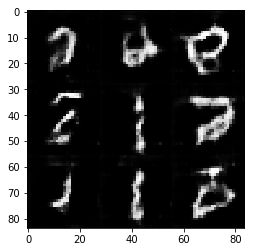

Epoch 1/2... Step 510... d_loss: 1.4543... g_loss: 0.4436 Elapsed: 3m3s
Epoch 1/2... Step 520... d_loss: 1.6749... g_loss: 0.3717 Elapsed: 3m3s
Epoch 1/2... Step 530... d_loss: 1.1914... g_loss: 0.6767 Elapsed: 3m3s
Epoch 1/2... Step 540... d_loss: 1.1839... g_loss: 0.6745 Elapsed: 3m3s
Epoch 1/2... Step 550... d_loss: 1.1294... g_loss: 1.0895 Elapsed: 3m3s
Epoch 1/2... Step 560... d_loss: 1.2681... g_loss: 1.1415 Elapsed: 3m3s
Epoch 1/2... Step 570... d_loss: 1.1717... g_loss: 0.9189 Elapsed: 3m3s
Epoch 1/2... Step 580... d_loss: 1.1990... g_loss: 0.6731 Elapsed: 3m3s
Epoch 1/2... Step 590... d_loss: 1.0448... g_loss: 1.1370 Elapsed: 4m4s
Epoch 1/2... Step 600... d_loss: 1.2588... g_loss: 0.6810 Elapsed: 4m4s
Sample output


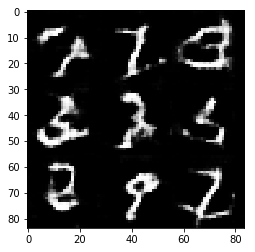

Epoch 1/2... Step 610... d_loss: 1.3518... g_loss: 0.5805 Elapsed: 4m4s
Epoch 1/2... Step 620... d_loss: 1.5880... g_loss: 0.3950 Elapsed: 4m4s
Epoch 1/2... Step 630... d_loss: 1.1465... g_loss: 0.9482 Elapsed: 4m4s
Epoch 1/2... Step 640... d_loss: 1.2059... g_loss: 0.9584 Elapsed: 4m4s
Epoch 1/2... Step 650... d_loss: 0.9984... g_loss: 1.0725 Elapsed: 4m4s
Epoch 1/2... Step 660... d_loss: 1.1299... g_loss: 0.7384 Elapsed: 4m4s
Epoch 1/2... Step 670... d_loss: 1.2609... g_loss: 0.6818 Elapsed: 4m4s
Epoch 1/2... Step 680... d_loss: 1.0876... g_loss: 0.8186 Elapsed: 4m4s
Epoch 1/2... Step 690... d_loss: 1.2807... g_loss: 0.6288 Elapsed: 4m4s
Epoch 1/2... Step 700... d_loss: 1.0669... g_loss: 1.0573 Elapsed: 4m4s
Sample output


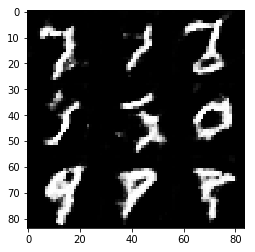

Epoch 1/2... Step 710... d_loss: 1.7291... g_loss: 0.3518 Elapsed: 4m4s
Epoch 1/2... Step 720... d_loss: 1.4662... g_loss: 0.5077 Elapsed: 4m4s
Epoch 1/2... Step 730... d_loss: 1.1271... g_loss: 0.7501 Elapsed: 4m4s
Epoch 1/2... Step 740... d_loss: 1.2400... g_loss: 0.6885 Elapsed: 5m5s
Epoch 1/2... Step 750... d_loss: 1.0205... g_loss: 1.3226 Elapsed: 5m5s
Epoch 1/2... Step 760... d_loss: 0.7211... g_loss: 1.6174 Elapsed: 5m5s
Epoch 1/2... Step 770... d_loss: 1.0947... g_loss: 0.9428 Elapsed: 5m5s
Epoch 1/2... Step 780... d_loss: 1.3529... g_loss: 0.5591 Elapsed: 5m5s
Epoch 1/2... Step 790... d_loss: 1.4879... g_loss: 0.4520 Elapsed: 5m5s
Epoch 1/2... Step 800... d_loss: 1.2642... g_loss: 0.5837 Elapsed: 5m5s
Sample output


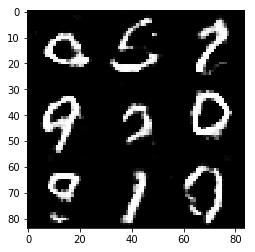

Epoch 1/2... Step 810... d_loss: 0.9489... g_loss: 0.9974 Elapsed: 5m5s
Epoch 1/2... Step 820... d_loss: 1.1790... g_loss: 0.6796 Elapsed: 5m5s
Epoch 1/2... Step 830... d_loss: 0.9585... g_loss: 1.0704 Elapsed: 5m5s
Epoch 1/2... Step 840... d_loss: 0.7563... g_loss: 1.6779 Elapsed: 5m5s
Epoch 1/2... Step 850... d_loss: 1.4370... g_loss: 0.4812 Elapsed: 5m5s
Epoch 1/2... Step 860... d_loss: 1.3725... g_loss: 0.5348 Elapsed: 5m5s
Epoch 1/2... Step 870... d_loss: 1.1069... g_loss: 0.7238 Elapsed: 5m5s
Epoch 1/2... Step 880... d_loss: 1.2585... g_loss: 0.5861 Elapsed: 5m5s
Epoch 1/2... Step 890... d_loss: 0.8480... g_loss: 1.3564 Elapsed: 6m6s
Epoch 1/2... Step 900... d_loss: 0.7369... g_loss: 1.5370 Elapsed: 6m6s
Sample output


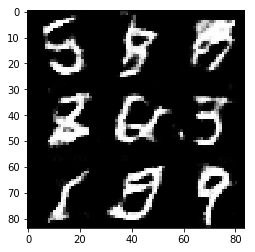

Epoch 1/2... Step 910... d_loss: 1.0529... g_loss: 1.6161 Elapsed: 6m6s
Epoch 1/2... Step 920... d_loss: 0.8263... g_loss: 1.3473 Elapsed: 6m6s
Epoch 1/2... Step 930... d_loss: 0.9965... g_loss: 0.8551 Elapsed: 6m6s
Epoch 1/2... Step 940... d_loss: 1.0579... g_loss: 0.7846 Elapsed: 6m6s
Epoch 1/2... Step 950... d_loss: 0.8458... g_loss: 1.2421 Elapsed: 6m6s
Epoch 1/2... Step 960... d_loss: 0.8227... g_loss: 1.1311 Elapsed: 6m6s
Epoch 1/2... Step 970... d_loss: 0.9025... g_loss: 1.0729 Elapsed: 6m6s
Epoch 1/2... Step 980... d_loss: 0.7428... g_loss: 1.6029 Elapsed: 6m6s
Epoch 1/2... Step 990... d_loss: 1.0327... g_loss: 0.8226 Elapsed: 6m6s
Epoch 1/2... Step 1000... d_loss: 1.0776... g_loss: 0.7898 Elapsed: 6m6s
Sample output


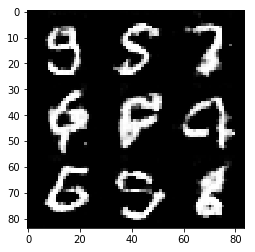

Epoch 1/2... Step 1010... d_loss: 1.2866... g_loss: 0.5864 Elapsed: 6m6s
Epoch 1/2... Step 1020... d_loss: 1.0855... g_loss: 0.7860 Elapsed: 6m6s
Epoch 1/2... Step 1030... d_loss: 1.6542... g_loss: 0.4216 Elapsed: 7m7s
Epoch 1/2... Step 1040... d_loss: 1.1264... g_loss: 0.8058 Elapsed: 7m7s
Epoch 1/2... Step 1050... d_loss: 0.8855... g_loss: 1.1260 Elapsed: 7m7s
Epoch 1/2... Step 1060... d_loss: 1.1674... g_loss: 0.6631 Elapsed: 7m7s
Epoch 1/2... Step 1070... d_loss: 0.8293... g_loss: 1.2092 Elapsed: 7m7s
Epoch 1/2... Step 1080... d_loss: 0.8247... g_loss: 1.2331 Elapsed: 7m7s
Epoch 1/2... Step 1090... d_loss: 1.3371... g_loss: 0.5490 Elapsed: 7m7s
Epoch 1/2... Step 1100... d_loss: 1.2684... g_loss: 0.5765 Elapsed: 7m7s
Sample output


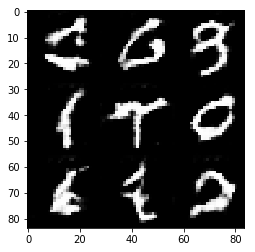

Epoch 1/2... Step 1110... d_loss: 1.6033... g_loss: 0.4324 Elapsed: 7m7s
Epoch 1/2... Step 1120... d_loss: 0.8145... g_loss: 1.3469 Elapsed: 7m7s
Epoch 1/2... Step 1130... d_loss: 1.2272... g_loss: 0.6062 Elapsed: 7m7s
Epoch 1/2... Step 1140... d_loss: 0.8196... g_loss: 1.2063 Elapsed: 7m7s
Epoch 1/2... Step 1150... d_loss: 1.1648... g_loss: 0.6963 Elapsed: 7m7s
Epoch 1/2... Step 1160... d_loss: 0.8917... g_loss: 1.1899 Elapsed: 7m7s
Epoch 1/2... Step 1170... d_loss: 1.2451... g_loss: 0.6137 Elapsed: 7m7s
Epoch 1/2... Step 1180... d_loss: 0.7837... g_loss: 1.3274 Elapsed: 7m7s
Epoch 1/2... Step 1190... d_loss: 0.8659... g_loss: 1.8120 Elapsed: 8m8s
Epoch 1/2... Step 1200... d_loss: 0.8644... g_loss: 1.0734 Elapsed: 8m8s
Sample output


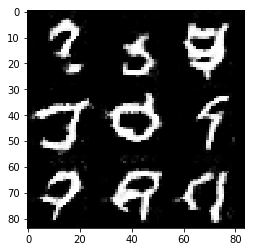

Epoch 1/2... Step 1210... d_loss: 0.7776... g_loss: 1.1904 Elapsed: 8m8s
Epoch 1/2... Step 1220... d_loss: 0.9358... g_loss: 0.9762 Elapsed: 8m8s
Epoch 1/2... Step 1230... d_loss: 1.0172... g_loss: 0.8882 Elapsed: 8m8s
Epoch 1/2... Step 1240... d_loss: 1.5821... g_loss: 0.3946 Elapsed: 8m8s
Epoch 1/2... Step 1250... d_loss: 0.9680... g_loss: 1.3547 Elapsed: 8m8s
Epoch 1/2... Step 1260... d_loss: 0.8522... g_loss: 1.6356 Elapsed: 8m8s
Epoch 1/2... Step 1270... d_loss: 0.8904... g_loss: 1.0947 Elapsed: 8m8s
Epoch 1/2... Step 1280... d_loss: 0.9344... g_loss: 0.9724 Elapsed: 8m8s
Epoch 1/2... Step 1290... d_loss: 0.9183... g_loss: 0.9992 Elapsed: 8m8s
Epoch 1/2... Step 1300... d_loss: 1.1588... g_loss: 0.7618 Elapsed: 8m8s
Sample output


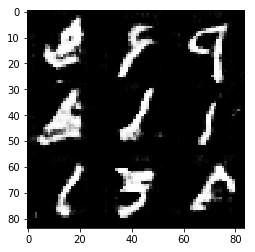

Epoch 1/2... Step 1310... d_loss: 0.6534... g_loss: 1.7539 Elapsed: 8m8s
Epoch 1/2... Step 1320... d_loss: 1.2973... g_loss: 0.5919 Elapsed: 8m8s
Epoch 1/2... Step 1330... d_loss: 1.0587... g_loss: 0.8109 Elapsed: 9m9s
Epoch 1/2... Step 1340... d_loss: 0.8136... g_loss: 2.0132 Elapsed: 9m9s
Epoch 1/2... Step 1350... d_loss: 1.2022... g_loss: 0.6898 Elapsed: 9m9s
Epoch 1/2... Step 1360... d_loss: 2.5260... g_loss: 0.1683 Elapsed: 9m9s
Epoch 1/2... Step 1370... d_loss: 1.5021... g_loss: 0.4578 Elapsed: 9m9s
Epoch 1/2... Step 1380... d_loss: 1.2430... g_loss: 0.6404 Elapsed: 9m9s
Epoch 1/2... Step 1390... d_loss: 0.8577... g_loss: 1.2993 Elapsed: 9m9s
Epoch 1/2... Step 1400... d_loss: 0.7907... g_loss: 1.3185 Elapsed: 9m9s
Sample output


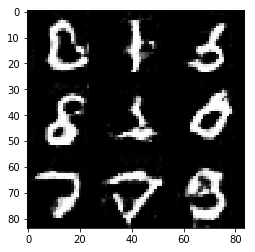

Epoch 1/2... Step 1410... d_loss: 0.7936... g_loss: 1.2099 Elapsed: 9m9s
Epoch 1/2... Step 1420... d_loss: 1.1837... g_loss: 0.7307 Elapsed: 9m9s
Epoch 1/2... Step 1430... d_loss: 1.0517... g_loss: 0.8959 Elapsed: 9m9s
Epoch 1/2... Step 1440... d_loss: 1.2136... g_loss: 0.6693 Elapsed: 9m9s
Epoch 1/2... Step 1450... d_loss: 1.1020... g_loss: 0.7517 Elapsed: 9m9s
Epoch 1/2... Step 1460... d_loss: 0.7682... g_loss: 1.2837 Elapsed: 9m9s
Epoch 1/2... Step 1470... d_loss: 1.0230... g_loss: 0.8701 Elapsed: 9m9s
Epoch 1/2... Step 1480... d_loss: 0.9063... g_loss: 1.0133 Elapsed: 10m10s
Epoch 1/2... Step 1490... d_loss: 1.1300... g_loss: 0.9461 Elapsed: 10m10s
Epoch 1/2... Step 1500... d_loss: 0.8647... g_loss: 1.0427 Elapsed: 10m10s
Sample output


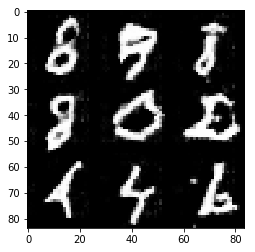

Epoch 1/2... Step 1510... d_loss: 1.4194... g_loss: 0.4737 Elapsed: 10m10s
Epoch 1/2... Step 1520... d_loss: 0.9698... g_loss: 0.8850 Elapsed: 10m10s
Epoch 1/2... Step 1530... d_loss: 1.2499... g_loss: 0.6345 Elapsed: 10m10s
Epoch 1/2... Step 1540... d_loss: 0.7217... g_loss: 1.7805 Elapsed: 10m10s
Epoch 1/2... Step 1550... d_loss: 0.7821... g_loss: 1.2523 Elapsed: 10m10s
Epoch 1/2... Step 1560... d_loss: 0.9442... g_loss: 0.9401 Elapsed: 10m10s
Epoch 1/2... Step 1570... d_loss: 0.8752... g_loss: 1.7130 Elapsed: 10m10s
Epoch 1/2... Step 1580... d_loss: 1.0852... g_loss: 0.8115 Elapsed: 10m10s
Epoch 1/2... Step 1590... d_loss: 0.8034... g_loss: 1.8121 Elapsed: 10m10s
Epoch 1/2... Step 1600... d_loss: 1.1519... g_loss: 0.7332 Elapsed: 10m10s
Sample output


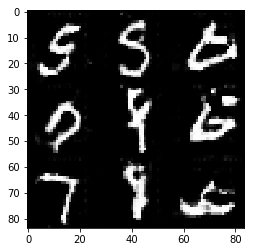

Epoch 1/2... Step 1610... d_loss: 0.9025... g_loss: 1.2734 Elapsed: 10m10s
Epoch 1/2... Step 1620... d_loss: 1.0413... g_loss: 0.8882 Elapsed: 10m10s
Epoch 1/2... Step 1630... d_loss: 0.8717... g_loss: 1.0464 Elapsed: 11m11s
Epoch 1/2... Step 1640... d_loss: 0.9126... g_loss: 0.9927 Elapsed: 11m11s
Epoch 1/2... Step 1650... d_loss: 0.7422... g_loss: 1.4999 Elapsed: 11m11s
Epoch 1/2... Step 1660... d_loss: 0.9773... g_loss: 0.8693 Elapsed: 11m11s
Epoch 1/2... Step 1670... d_loss: 1.3049... g_loss: 0.5783 Elapsed: 11m11s
Epoch 1/2... Step 1680... d_loss: 0.6690... g_loss: 1.5966 Elapsed: 11m11s
Epoch 1/2... Step 1690... d_loss: 0.8874... g_loss: 1.0481 Elapsed: 11m11s
Epoch 1/2... Step 1700... d_loss: 1.0666... g_loss: 0.8617 Elapsed: 11m11s
Sample output


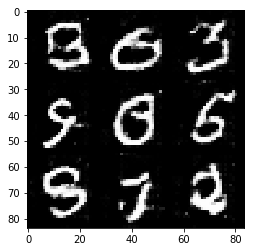

Epoch 1/2... Step 1710... d_loss: 0.8379... g_loss: 1.2766 Elapsed: 11m11s
Epoch 1/2... Step 1720... d_loss: 0.9102... g_loss: 2.7626 Elapsed: 11m11s
Epoch 1/2... Step 1730... d_loss: 1.7150... g_loss: 0.3911 Elapsed: 11m11s
Epoch 1/2... Step 1740... d_loss: 0.8649... g_loss: 1.3756 Elapsed: 11m11s
Epoch 1/2... Step 1750... d_loss: 0.6669... g_loss: 1.7189 Elapsed: 11m11s
Epoch 1/2... Step 1760... d_loss: 0.9181... g_loss: 0.9321 Elapsed: 11m11s
Epoch 1/2... Step 1770... d_loss: 0.8438... g_loss: 1.2285 Elapsed: 11m11s
Epoch 1/2... Step 1780... d_loss: 0.6684... g_loss: 1.5550 Elapsed: 12m12s
Epoch 1/2... Step 1790... d_loss: 0.6907... g_loss: 1.4603 Elapsed: 12m12s
Epoch 1/2... Step 1800... d_loss: 0.6637... g_loss: 1.6176 Elapsed: 12m12s
Sample output


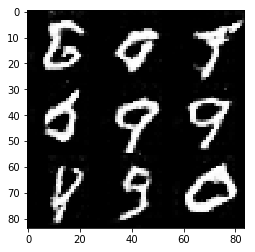

Epoch 1/2... Step 1810... d_loss: 0.9149... g_loss: 0.9665 Elapsed: 12m12s
Epoch 1/2... Step 1820... d_loss: 0.7736... g_loss: 1.2261 Elapsed: 12m12s
Epoch 1/2... Step 1830... d_loss: 1.2654... g_loss: 0.5936 Elapsed: 12m12s
Epoch 1/2... Step 1840... d_loss: 0.8698... g_loss: 1.0554 Elapsed: 12m12s
Epoch 1/2... Step 1850... d_loss: 0.9970... g_loss: 0.8196 Elapsed: 12m12s
Epoch 1/2... Step 1860... d_loss: 1.2046... g_loss: 0.6480 Elapsed: 12m12s
Epoch 1/2... Step 1870... d_loss: 0.6159... g_loss: 1.7574 Elapsed: 12m12s
Epoch 2/2... Step 1880... d_loss: 0.8418... g_loss: 1.2470 Elapsed: 12m12s
Epoch 2/2... Step 1890... d_loss: 0.6688... g_loss: 2.0816 Elapsed: 12m12s
Epoch 2/2... Step 1900... d_loss: 0.9051... g_loss: 2.0628 Elapsed: 12m12s
Sample output


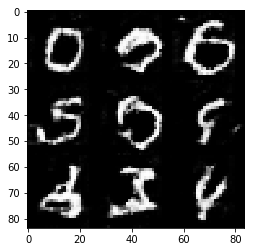

Epoch 2/2... Step 1910... d_loss: 0.7659... g_loss: 1.3493 Elapsed: 12m12s
Epoch 2/2... Step 1920... d_loss: 0.8018... g_loss: 1.2931 Elapsed: 12m12s
Epoch 2/2... Step 1930... d_loss: 1.0150... g_loss: 0.8701 Elapsed: 13m13s
Epoch 2/2... Step 1940... d_loss: 1.0214... g_loss: 0.8119 Elapsed: 13m13s
Epoch 2/2... Step 1950... d_loss: 0.6112... g_loss: 2.6726 Elapsed: 13m13s
Epoch 2/2... Step 1960... d_loss: 0.7472... g_loss: 1.4551 Elapsed: 13m13s
Epoch 2/2... Step 1970... d_loss: 1.2477... g_loss: 0.6771 Elapsed: 13m13s
Epoch 2/2... Step 1980... d_loss: 1.0411... g_loss: 0.8548 Elapsed: 13m13s
Epoch 2/2... Step 1990... d_loss: 0.8023... g_loss: 1.1655 Elapsed: 13m13s
Epoch 2/2... Step 2000... d_loss: 0.9485... g_loss: 0.9894 Elapsed: 13m13s
Sample output


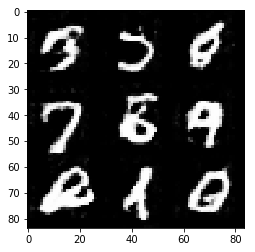

Epoch 2/2... Step 2010... d_loss: 0.7372... g_loss: 1.4039 Elapsed: 13m13s
Epoch 2/2... Step 2020... d_loss: 0.9000... g_loss: 1.0538 Elapsed: 13m13s
Epoch 2/2... Step 2030... d_loss: 0.9860... g_loss: 0.8543 Elapsed: 13m13s
Epoch 2/2... Step 2040... d_loss: 0.9325... g_loss: 1.0045 Elapsed: 13m13s
Epoch 2/2... Step 2050... d_loss: 0.7479... g_loss: 1.4641 Elapsed: 13m13s
Epoch 2/2... Step 2060... d_loss: 0.6326... g_loss: 1.6694 Elapsed: 13m13s
Epoch 2/2... Step 2070... d_loss: 1.0688... g_loss: 0.7869 Elapsed: 13m13s
Epoch 2/2... Step 2080... d_loss: 1.3405... g_loss: 0.5707 Elapsed: 14m14s
Epoch 2/2... Step 2090... d_loss: 0.9228... g_loss: 1.1022 Elapsed: 14m14s
Epoch 2/2... Step 2100... d_loss: 0.6187... g_loss: 1.5641 Elapsed: 14m14s
Sample output


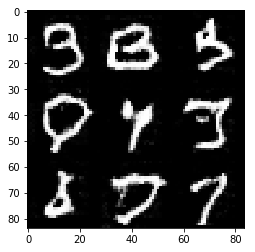

Epoch 2/2... Step 2110... d_loss: 0.9759... g_loss: 0.8886 Elapsed: 14m14s
Epoch 2/2... Step 2120... d_loss: 0.6786... g_loss: 1.4785 Elapsed: 14m14s
Epoch 2/2... Step 2130... d_loss: 0.8622... g_loss: 1.1250 Elapsed: 14m14s
Epoch 2/2... Step 2140... d_loss: 0.7567... g_loss: 1.5474 Elapsed: 14m14s
Epoch 2/2... Step 2150... d_loss: 1.4717... g_loss: 0.5214 Elapsed: 14m14s
Epoch 2/2... Step 2160... d_loss: 0.8011... g_loss: 1.1275 Elapsed: 14m14s
Epoch 2/2... Step 2170... d_loss: 0.6313... g_loss: 1.8721 Elapsed: 14m14s
Epoch 2/2... Step 2180... d_loss: 0.8062... g_loss: 1.1840 Elapsed: 14m14s
Epoch 2/2... Step 2190... d_loss: 0.6009... g_loss: 1.6864 Elapsed: 14m14s
Epoch 2/2... Step 2200... d_loss: 0.9705... g_loss: 0.8876 Elapsed: 14m14s
Sample output


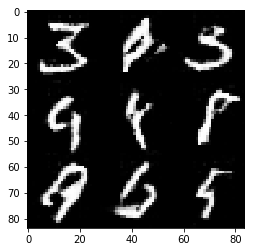

Epoch 2/2... Step 2210... d_loss: 0.6875... g_loss: 1.5499 Elapsed: 14m14s
Epoch 2/2... Step 2220... d_loss: 0.7296... g_loss: 1.3116 Elapsed: 14m14s
Epoch 2/2... Step 2230... d_loss: 0.6988... g_loss: 2.0639 Elapsed: 15m15s
Epoch 2/2... Step 2240... d_loss: 0.6882... g_loss: 1.4094 Elapsed: 15m15s
Epoch 2/2... Step 2250... d_loss: 0.8320... g_loss: 1.2420 Elapsed: 15m15s
Epoch 2/2... Step 2260... d_loss: 0.6274... g_loss: 1.8304 Elapsed: 15m15s
Epoch 2/2... Step 2270... d_loss: 0.7243... g_loss: 1.5427 Elapsed: 15m15s
Epoch 2/2... Step 2280... d_loss: 0.6338... g_loss: 1.5181 Elapsed: 15m15s
Epoch 2/2... Step 2290... d_loss: 0.6300... g_loss: 1.9243 Elapsed: 15m15s
Epoch 2/2... Step 2300... d_loss: 0.7641... g_loss: 1.3675 Elapsed: 15m15s
Sample output


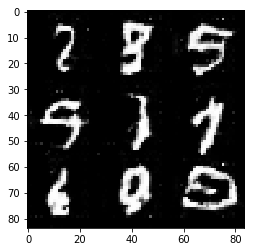

Epoch 2/2... Step 2310... d_loss: 0.7325... g_loss: 1.5015 Elapsed: 15m15s
Epoch 2/2... Step 2320... d_loss: 0.6553... g_loss: 1.5757 Elapsed: 15m15s
Epoch 2/2... Step 2330... d_loss: 1.2376... g_loss: 0.6190 Elapsed: 15m15s
Epoch 2/2... Step 2340... d_loss: 1.2437... g_loss: 0.7368 Elapsed: 15m15s
Epoch 2/2... Step 2350... d_loss: 0.6414... g_loss: 1.7159 Elapsed: 15m15s
Epoch 2/2... Step 2360... d_loss: 0.9775... g_loss: 0.9133 Elapsed: 15m15s
Epoch 2/2... Step 2370... d_loss: 0.8805... g_loss: 1.1071 Elapsed: 15m15s
Epoch 2/2... Step 2380... d_loss: 1.1553... g_loss: 0.7310 Elapsed: 16m16s
Epoch 2/2... Step 2390... d_loss: 0.6977... g_loss: 1.5262 Elapsed: 16m16s
Epoch 2/2... Step 2400... d_loss: 0.9374... g_loss: 0.9966 Elapsed: 16m16s
Sample output


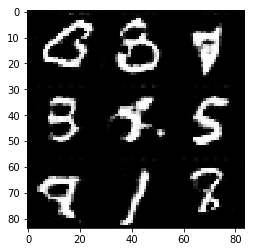

Epoch 2/2... Step 2410... d_loss: 0.8566... g_loss: 1.0840 Elapsed: 16m16s
Epoch 2/2... Step 2420... d_loss: 0.6497... g_loss: 1.7386 Elapsed: 16m16s
Epoch 2/2... Step 2430... d_loss: 0.8469... g_loss: 1.1132 Elapsed: 16m16s
Epoch 2/2... Step 2440... d_loss: 0.6185... g_loss: 1.9002 Elapsed: 16m16s
Epoch 2/2... Step 2450... d_loss: 0.8243... g_loss: 2.0918 Elapsed: 16m16s
Epoch 2/2... Step 2460... d_loss: 1.0192... g_loss: 0.8799 Elapsed: 16m16s
Epoch 2/2... Step 2470... d_loss: 2.0281... g_loss: 0.3020 Elapsed: 16m16s
Epoch 2/2... Step 2480... d_loss: 0.8505... g_loss: 1.2344 Elapsed: 16m16s
Epoch 2/2... Step 2490... d_loss: 0.7409... g_loss: 1.2718 Elapsed: 16m16s
Epoch 2/2... Step 2500... d_loss: 0.8115... g_loss: 1.2695 Elapsed: 16m16s
Sample output


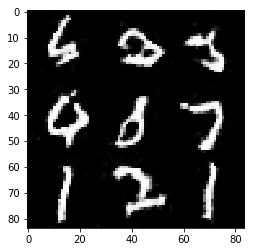

Epoch 2/2... Step 2510... d_loss: 1.4272... g_loss: 0.4853 Elapsed: 16m16s
Epoch 2/2... Step 2520... d_loss: 1.0467... g_loss: 1.4258 Elapsed: 16m16s
Epoch 2/2... Step 2530... d_loss: 0.8375... g_loss: 1.1877 Elapsed: 17m17s
Epoch 2/2... Step 2540... d_loss: 0.8736... g_loss: 1.2188 Elapsed: 17m17s
Epoch 2/2... Step 2550... d_loss: 0.8734... g_loss: 1.1900 Elapsed: 17m17s
Epoch 2/2... Step 2560... d_loss: 0.6711... g_loss: 1.4463 Elapsed: 17m17s
Epoch 2/2... Step 2570... d_loss: 0.9418... g_loss: 0.9558 Elapsed: 17m17s
Epoch 2/2... Step 2580... d_loss: 0.7598... g_loss: 1.3729 Elapsed: 17m17s
Epoch 2/2... Step 2590... d_loss: 0.7688... g_loss: 1.3509 Elapsed: 17m17s
Epoch 2/2... Step 2600... d_loss: 0.7129... g_loss: 2.2612 Elapsed: 17m17s
Sample output


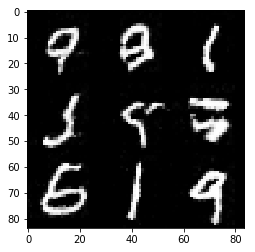

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Parameters:
epoch_count: 1
batch_size: 128
z_dim: 100
learning_rate: 0.005
beta1: 0.2
data_shape: (202599, 28, 28, 3)
Getting model inputs... Ok
Calculating model loss... Ok
Getting model optimizers ... Ok
Starting training
Epoch 1/1... Step 10... d_loss: 4.1921... g_loss: 0.0854 Elapsed: 0m0s
Epoch 1/1... Step 20... d_loss: 3.0552... g_loss: 0.1006 Elapsed: 0m0s
Epoch 1/1... Step 30... d_loss: 0.5868... g_loss: 2.6671 Elapsed: 0m0s
Epoch 1/1... Step 40... d_loss: 2.5721... g_loss: 0.1537 Elapsed: 0m0s
Epoch 1/1... Step 50... d_loss: 0.6912... g_loss: 2.4903 Elapsed: 1m1s
Epoch 1/1... Step 60... d_loss: 0.8908... g_loss: 1.0306 Elapsed: 1m1s
Epoch 1/1... Step 70... d_loss: 0.7937... g_loss: 1.2695 Elapsed: 1m1s
Epoch 1/1... Step 80... d_loss: 0.7576... g_loss: 1.4147 Elapsed: 1m1s
Epoch 1/1... Step 90... d_loss: 0.4567... g_loss: 2.9590 Elapsed: 1m1s
Epoch 1/1... Step 100... d_loss: 1.4794... g_loss: 0.5341 Elapsed: 2m2s
Sample output


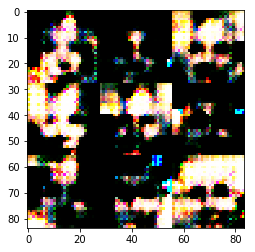

Epoch 1/1... Step 110... d_loss: 1.8993... g_loss: 1.3841 Elapsed: 2m2s
Epoch 1/1... Step 120... d_loss: 1.8102... g_loss: 2.0161 Elapsed: 2m2s
Epoch 1/1... Step 130... d_loss: 0.9553... g_loss: 1.2177 Elapsed: 2m2s
Epoch 1/1... Step 140... d_loss: 1.4106... g_loss: 1.2216 Elapsed: 2m2s
Epoch 1/1... Step 150... d_loss: 1.0735... g_loss: 0.9369 Elapsed: 3m3s
Epoch 1/1... Step 160... d_loss: 0.9282... g_loss: 1.0837 Elapsed: 3m3s
Epoch 1/1... Step 170... d_loss: 1.0654... g_loss: 2.3960 Elapsed: 3m3s
Epoch 1/1... Step 180... d_loss: 0.8604... g_loss: 1.1231 Elapsed: 3m3s
Epoch 1/1... Step 190... d_loss: 0.5243... g_loss: 2.0603 Elapsed: 4m4s
Epoch 1/1... Step 200... d_loss: 1.0857... g_loss: 0.9964 Elapsed: 4m4s
Sample output


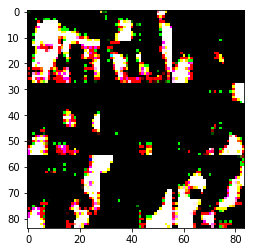

Epoch 1/1... Step 210... d_loss: 1.0411... g_loss: 1.0546 Elapsed: 4m4s
Epoch 1/1... Step 220... d_loss: 0.7377... g_loss: 2.0024 Elapsed: 4m4s
Epoch 1/1... Step 230... d_loss: 1.1126... g_loss: 1.9466 Elapsed: 4m4s
Epoch 1/1... Step 240... d_loss: 1.3323... g_loss: 1.4134 Elapsed: 5m5s
Epoch 1/1... Step 250... d_loss: 1.0658... g_loss: 1.0139 Elapsed: 5m5s
Epoch 1/1... Step 260... d_loss: 0.8876... g_loss: 1.1928 Elapsed: 5m5s
Epoch 1/1... Step 270... d_loss: 1.5433... g_loss: 1.7485 Elapsed: 5m5s
Epoch 1/1... Step 280... d_loss: 0.4664... g_loss: 2.5315 Elapsed: 5m5s
Epoch 1/1... Step 290... d_loss: 0.4333... g_loss: 2.7187 Elapsed: 6m6s
Epoch 1/1... Step 300... d_loss: 0.3951... g_loss: 3.1682 Elapsed: 6m6s
Sample output


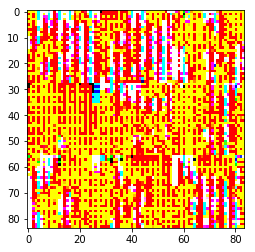

Epoch 1/1... Step 310... d_loss: 4.4415... g_loss: 4.6201 Elapsed: 6m6s
Epoch 1/1... Step 320... d_loss: 0.9375... g_loss: 1.0065 Elapsed: 6m6s
Epoch 1/1... Step 330... d_loss: 0.9084... g_loss: 0.9440 Elapsed: 6m6s
Epoch 1/1... Step 340... d_loss: 1.4864... g_loss: 1.8798 Elapsed: 7m7s
Epoch 1/1... Step 350... d_loss: 1.5178... g_loss: 0.4887 Elapsed: 7m7s
Epoch 1/1... Step 360... d_loss: 0.8773... g_loss: 1.1408 Elapsed: 7m7s
Epoch 1/1... Step 370... d_loss: 0.8850... g_loss: 1.0979 Elapsed: 7m7s
Epoch 1/1... Step 380... d_loss: 0.5251... g_loss: 2.1571 Elapsed: 8m8s
Epoch 1/1... Step 390... d_loss: 1.1856... g_loss: 2.3874 Elapsed: 8m8s
Epoch 1/1... Step 400... d_loss: 0.6257... g_loss: 1.6752 Elapsed: 8m8s
Sample output


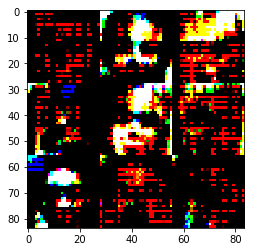

Epoch 1/1... Step 410... d_loss: 1.2348... g_loss: 1.0544 Elapsed: 8m8s
Epoch 1/1... Step 420... d_loss: 1.9950... g_loss: 0.3013 Elapsed: 8m8s
Epoch 1/1... Step 430... d_loss: 0.8531... g_loss: 1.6101 Elapsed: 9m9s
Epoch 1/1... Step 440... d_loss: 1.0473... g_loss: 0.8318 Elapsed: 9m9s
Epoch 1/1... Step 450... d_loss: 0.9952... g_loss: 1.1715 Elapsed: 9m9s
Epoch 1/1... Step 460... d_loss: 0.8081... g_loss: 1.2501 Elapsed: 9m9s
Epoch 1/1... Step 470... d_loss: 2.5603... g_loss: 0.1818 Elapsed: 9m9s
Epoch 1/1... Step 480... d_loss: 1.1529... g_loss: 1.3488 Elapsed: 10m10s
Epoch 1/1... Step 490... d_loss: 0.6548... g_loss: 3.5723 Elapsed: 10m10s
Epoch 1/1... Step 500... d_loss: 0.9038... g_loss: 1.0781 Elapsed: 10m10s
Sample output


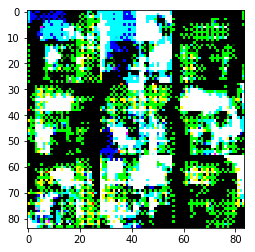

Epoch 1/1... Step 510... d_loss: 1.3109... g_loss: 1.1976 Elapsed: 10m10s
Epoch 1/1... Step 520... d_loss: 0.7800... g_loss: 1.7720 Elapsed: 11m11s
Epoch 1/1... Step 530... d_loss: 1.4768... g_loss: 0.6214 Elapsed: 11m11s
Epoch 1/1... Step 540... d_loss: 1.3812... g_loss: 0.8579 Elapsed: 11m11s
Epoch 1/1... Step 550... d_loss: 1.3053... g_loss: 1.3614 Elapsed: 11m11s
Epoch 1/1... Step 560... d_loss: 1.2434... g_loss: 1.4024 Elapsed: 11m11s
Epoch 1/1... Step 570... d_loss: 1.2742... g_loss: 0.7387 Elapsed: 12m12s
Epoch 1/1... Step 580... d_loss: 1.1744... g_loss: 0.8548 Elapsed: 12m12s
Epoch 1/1... Step 590... d_loss: 1.3618... g_loss: 0.8877 Elapsed: 12m12s
Epoch 1/1... Step 600... d_loss: 1.2505... g_loss: 0.7744 Elapsed: 12m12s
Sample output


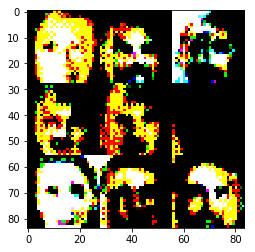

Epoch 1/1... Step 610... d_loss: 1.2996... g_loss: 1.1715 Elapsed: 12m12s
Epoch 1/1... Step 620... d_loss: 1.0303... g_loss: 1.0642 Elapsed: 13m13s
Epoch 1/1... Step 630... d_loss: 1.0301... g_loss: 0.9325 Elapsed: 13m13s
Epoch 1/1... Step 640... d_loss: 1.5492... g_loss: 0.3756 Elapsed: 13m13s
Epoch 1/1... Step 650... d_loss: 0.7941... g_loss: 1.2656 Elapsed: 13m13s
Epoch 1/1... Step 660... d_loss: 1.7224... g_loss: 0.5479 Elapsed: 13m13s
Epoch 1/1... Step 670... d_loss: 1.1957... g_loss: 1.1982 Elapsed: 14m14s
Epoch 1/1... Step 680... d_loss: 1.1990... g_loss: 0.6439 Elapsed: 14m14s
Epoch 1/1... Step 690... d_loss: 1.3872... g_loss: 0.6239 Elapsed: 14m14s
Epoch 1/1... Step 700... d_loss: 1.3552... g_loss: 0.7297 Elapsed: 14m14s
Sample output


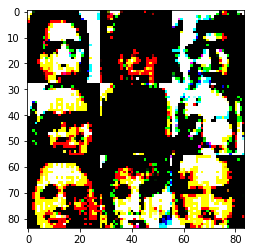

Epoch 1/1... Step 710... d_loss: 1.1136... g_loss: 1.5604 Elapsed: 15m15s
Epoch 1/1... Step 720... d_loss: 1.4888... g_loss: 0.5846 Elapsed: 15m15s
Epoch 1/1... Step 730... d_loss: 1.0020... g_loss: 0.8925 Elapsed: 15m15s
Epoch 1/1... Step 740... d_loss: 1.3119... g_loss: 0.9778 Elapsed: 15m15s
Epoch 1/1... Step 750... d_loss: 0.4967... g_loss: 2.2820 Elapsed: 15m15s
Epoch 1/1... Step 760... d_loss: 0.7590... g_loss: 1.2712 Elapsed: 16m16s
Epoch 1/1... Step 770... d_loss: 1.2256... g_loss: 0.7052 Elapsed: 16m16s
Epoch 1/1... Step 780... d_loss: 1.1345... g_loss: 0.8959 Elapsed: 16m16s
Epoch 1/1... Step 790... d_loss: 1.5819... g_loss: 0.5071 Elapsed: 16m16s
Epoch 1/1... Step 800... d_loss: 0.9485... g_loss: 1.0272 Elapsed: 16m16s
Sample output


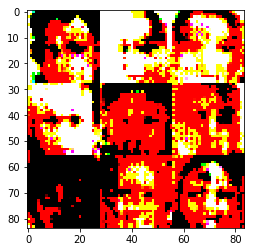

Epoch 1/1... Step 810... d_loss: 1.7208... g_loss: 0.3304 Elapsed: 17m17s
Epoch 1/1... Step 820... d_loss: 1.3099... g_loss: 0.5198 Elapsed: 17m17s
Epoch 1/1... Step 830... d_loss: 0.5030... g_loss: 2.0891 Elapsed: 17m17s
Epoch 1/1... Step 840... d_loss: 1.8272... g_loss: 4.1310 Elapsed: 17m17s
Epoch 1/1... Step 850... d_loss: 1.1214... g_loss: 5.0563 Elapsed: 17m17s
Epoch 1/1... Step 860... d_loss: 1.2878... g_loss: 2.0768 Elapsed: 18m18s
Epoch 1/1... Step 870... d_loss: 0.8662... g_loss: 1.0631 Elapsed: 18m18s
Epoch 1/1... Step 880... d_loss: 2.7381... g_loss: 0.1609 Elapsed: 18m18s
Epoch 1/1... Step 890... d_loss: 0.8356... g_loss: 1.1468 Elapsed: 18m18s
Epoch 1/1... Step 900... d_loss: 1.1652... g_loss: 0.6801 Elapsed: 19m19s
Sample output


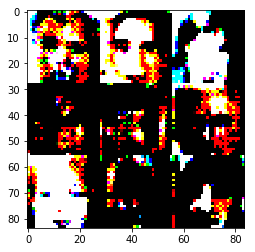

Epoch 1/1... Step 910... d_loss: 1.0023... g_loss: 0.8962 Elapsed: 19m19s
Epoch 1/1... Step 920... d_loss: 1.2373... g_loss: 1.0130 Elapsed: 19m19s
Epoch 1/1... Step 930... d_loss: 1.5014... g_loss: 0.6617 Elapsed: 19m19s
Epoch 1/1... Step 940... d_loss: 1.6932... g_loss: 0.3373 Elapsed: 19m19s
Epoch 1/1... Step 950... d_loss: 1.4083... g_loss: 0.6694 Elapsed: 20m20s
Epoch 1/1... Step 960... d_loss: 0.3858... g_loss: 3.5001 Elapsed: 20m20s
Epoch 1/1... Step 970... d_loss: 0.7273... g_loss: 1.6401 Elapsed: 20m20s
Epoch 1/1... Step 980... d_loss: 0.6929... g_loss: 1.3857 Elapsed: 20m20s
Epoch 1/1... Step 990... d_loss: 1.6981... g_loss: 0.7956 Elapsed: 20m20s
Epoch 1/1... Step 1000... d_loss: 0.9913... g_loss: 0.9376 Elapsed: 21m21s
Sample output


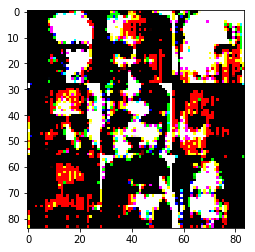

Epoch 1/1... Step 1010... d_loss: 0.9674... g_loss: 0.9679 Elapsed: 21m21s
Epoch 1/1... Step 1020... d_loss: 1.7169... g_loss: 1.6941 Elapsed: 21m21s
Epoch 1/1... Step 1030... d_loss: 1.2326... g_loss: 0.8815 Elapsed: 21m21s
Epoch 1/1... Step 1040... d_loss: 1.4616... g_loss: 0.5132 Elapsed: 21m21s
Epoch 1/1... Step 1050... d_loss: 1.1969... g_loss: 0.7635 Elapsed: 22m22s
Epoch 1/1... Step 1060... d_loss: 0.9388... g_loss: 1.2249 Elapsed: 22m22s
Epoch 1/1... Step 1070... d_loss: 1.1614... g_loss: 0.7954 Elapsed: 22m22s
Epoch 1/1... Step 1080... d_loss: 1.5907... g_loss: 0.4319 Elapsed: 22m22s
Epoch 1/1... Step 1090... d_loss: 1.4048... g_loss: 0.4640 Elapsed: 23m23s
Epoch 1/1... Step 1100... d_loss: 1.2837... g_loss: 0.6665 Elapsed: 23m23s
Sample output


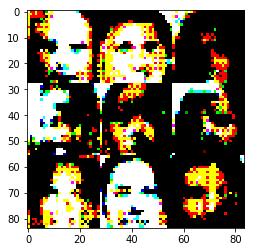

Epoch 1/1... Step 1110... d_loss: 1.2193... g_loss: 1.2414 Elapsed: 23m23s
Epoch 1/1... Step 1120... d_loss: 1.0798... g_loss: 0.8894 Elapsed: 23m23s
Epoch 1/1... Step 1130... d_loss: 1.1581... g_loss: 0.8057 Elapsed: 23m23s
Epoch 1/1... Step 1140... d_loss: 1.1863... g_loss: 0.9334 Elapsed: 24m24s
Epoch 1/1... Step 1150... d_loss: 1.1005... g_loss: 1.0687 Elapsed: 24m24s
Epoch 1/1... Step 1160... d_loss: 1.1817... g_loss: 0.9141 Elapsed: 24m24s
Epoch 1/1... Step 1170... d_loss: 1.2559... g_loss: 0.7631 Elapsed: 24m24s
Epoch 1/1... Step 1180... d_loss: 1.3227... g_loss: 0.7117 Elapsed: 24m24s
Epoch 1/1... Step 1190... d_loss: 1.1885... g_loss: 0.6966 Elapsed: 25m25s
Epoch 1/1... Step 1200... d_loss: 1.4634... g_loss: 0.6697 Elapsed: 25m25s
Sample output


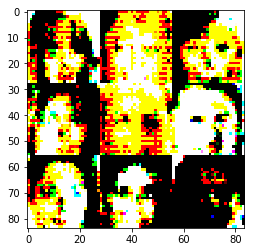

Epoch 1/1... Step 1210... d_loss: 1.1077... g_loss: 0.7553 Elapsed: 25m25s
Epoch 1/1... Step 1220... d_loss: 1.2191... g_loss: 0.8034 Elapsed: 25m25s
Epoch 1/1... Step 1230... d_loss: 1.5452... g_loss: 0.4694 Elapsed: 26m26s
Epoch 1/1... Step 1240... d_loss: 1.1083... g_loss: 0.7850 Elapsed: 26m26s
Epoch 1/1... Step 1250... d_loss: 1.1305... g_loss: 1.6065 Elapsed: 26m26s
Epoch 1/1... Step 1260... d_loss: 1.1631... g_loss: 0.8156 Elapsed: 26m26s
Epoch 1/1... Step 1270... d_loss: 0.9451... g_loss: 0.8508 Elapsed: 26m26s
Epoch 1/1... Step 1280... d_loss: 2.1557... g_loss: 0.2534 Elapsed: 27m27s
Epoch 1/1... Step 1290... d_loss: 1.5289... g_loss: 0.6644 Elapsed: 27m27s
Epoch 1/1... Step 1300... d_loss: 1.1597... g_loss: 0.8721 Elapsed: 27m27s
Sample output


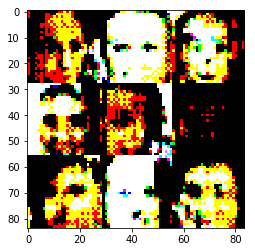

Epoch 1/1... Step 1310... d_loss: 1.3876... g_loss: 0.6530 Elapsed: 27m27s
Epoch 1/1... Step 1320... d_loss: 2.7992... g_loss: 3.1312 Elapsed: 27m27s
Epoch 1/1... Step 1330... d_loss: 0.7024... g_loss: 2.9987 Elapsed: 28m28s
Epoch 1/1... Step 1340... d_loss: 0.3659... g_loss: 4.5974 Elapsed: 28m28s
Epoch 1/1... Step 1350... d_loss: 2.2516... g_loss: 0.2668 Elapsed: 28m28s
Epoch 1/1... Step 1360... d_loss: 0.8383... g_loss: 1.2452 Elapsed: 28m28s
Epoch 1/1... Step 1370... d_loss: 0.9957... g_loss: 0.9313 Elapsed: 28m28s
Epoch 1/1... Step 1380... d_loss: 0.9085... g_loss: 1.3722 Elapsed: 29m29s
Epoch 1/1... Step 1390... d_loss: 0.7692... g_loss: 1.3403 Elapsed: 29m29s
Epoch 1/1... Step 1400... d_loss: 1.0548... g_loss: 1.0240 Elapsed: 29m29s
Sample output


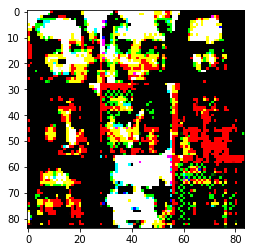

Epoch 1/1... Step 1410... d_loss: 1.4800... g_loss: 1.8516 Elapsed: 29m29s
Epoch 1/1... Step 1420... d_loss: 0.9595... g_loss: 1.6582 Elapsed: 30m30s
Epoch 1/1... Step 1430... d_loss: 1.2186... g_loss: 0.9768 Elapsed: 30m30s
Epoch 1/1... Step 1440... d_loss: 2.2756... g_loss: 3.1770 Elapsed: 30m30s
Epoch 1/1... Step 1450... d_loss: 1.2087... g_loss: 0.6888 Elapsed: 30m30s
Epoch 1/1... Step 1460... d_loss: 1.1843... g_loss: 1.2237 Elapsed: 30m30s
Epoch 1/1... Step 1470... d_loss: 1.2794... g_loss: 1.4249 Elapsed: 31m31s
Epoch 1/1... Step 1480... d_loss: 0.4290... g_loss: 3.0027 Elapsed: 31m31s
Epoch 1/1... Step 1490... d_loss: 0.4333... g_loss: 2.8513 Elapsed: 31m31s
Epoch 1/1... Step 1500... d_loss: 2.2186... g_loss: 5.2532 Elapsed: 31m31s
Sample output


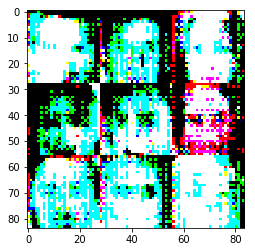

Epoch 1/1... Step 1510... d_loss: 0.9023... g_loss: 1.0366 Elapsed: 31m31s
Epoch 1/1... Step 1520... d_loss: 1.2332... g_loss: 0.6124 Elapsed: 32m32s
Epoch 1/1... Step 1530... d_loss: 0.9979... g_loss: 1.5214 Elapsed: 32m32s
Epoch 1/1... Step 1540... d_loss: 1.1112... g_loss: 0.8953 Elapsed: 32m32s
Epoch 1/1... Step 1550... d_loss: 1.6903... g_loss: 0.3843 Elapsed: 32m32s
Epoch 1/1... Step 1560... d_loss: 1.9490... g_loss: 0.3156 Elapsed: 33m33s
Epoch 1/1... Step 1570... d_loss: 1.2153... g_loss: 0.8772 Elapsed: 33m33s
Epoch 1/1... Step 1580... d_loss: 1.1605... g_loss: 0.9821 Elapsed: 33m33s
Training done


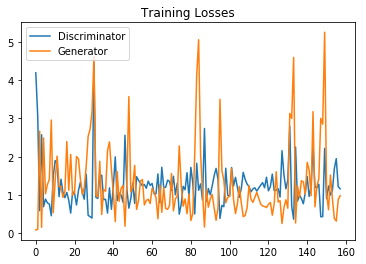

In [135]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.